In [1]:
from qiskit import QuantumCircuit
circuit = QuantumCircuit(1)
circuit.h(0)
circuit.s(0)
circuit.h(0)
circuit.t(0)
circuit.draw()

┌───┐┌───┐┌───┐┌───┐
q: ┤ H ├┤ S ├┤ H ├┤ T ├
   └───┘└───┘└───┘└───┘

In [11]:
from qiskit import QuantumCircuit, QuantumRegister
X = QuantumRegister(1, "Phat")
circuit = QuantumCircuit(X)
circuit.h(X)
circuit.s(X)
circuit.h(X)
circuit.t(X)
circuit.draw()

┌───┐┌───┐┌───┐┌───┐
Phat: ┤ H ├┤ S ├┤ H ├┤ T ├
      └───┘└───┘└───┘└───┘

In [12]:
#implement of this circuit using Qiskit 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
X = QuantumRegister(1, "x")
Y = QuantumRegister(1, "y")
A = ClassicalRegister(1, "a")
B = ClassicalRegister(1, "b")
circuit = QuantumCircuit(Y, X, B, A)
circuit.h(Y)
circuit.cx(Y, X)

circuit.measure(Y, B)
circuit.measure(X, A)
circuit.draw()

┌───┐     ┌─┐   
  y: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
  x: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
b: 1/═══════════╩══╬═
                0  ║ 
a: 1/══════════════╩═
                   0

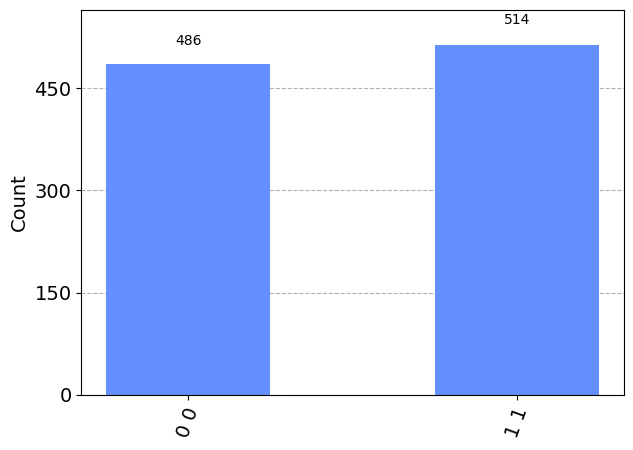

In [13]:
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

simulator = AerSimulator()
circuit_simulator = simulator.run(transpile(circuit,simulator), shots=1000)
statistics = circuit_simulator.result().get_counts()
plot_histogram(statistics)

In [14]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

protocol.draw()

░      ┌───┐ ░    ┌─┐ ░                         
Q: ───────────░───■──┤ H ├─░────┤M├─░─────────────────────────
   ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░                         
A: ┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─────────────────────────
   └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ ┌──────────┐┌──────────┐
B: ─────┤ X ├─░────────────░──╫──╫──░─┤0         ├┤0         ├
        └───┘ ░            ░  ║  ║  ░ │  If_else ││          │
a: ═══════════════════════════╩══╬════╡0         ╞╡          ╞
                                 ║    └──────────┘│          │
b: ══════════════════════════════╩════════════════╡0         ╞
                                                  └──────────┘

In [16]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol, along with a new "auxiliary" qubit R.
aux = QuantumRegister(1, "R")
test = QuantumCircuit(aux, qubit, ebit0, ebit1, a, b)

# Entangle Q with R
test.h(aux)
test.cx(aux, qubit)
test.barrier()

# Append the protocol the circuit. The 'qubits' argument tells Qiskit that
# the protocol should operate on the qubits numbered 1, 2, and 3 (skipping
# qubit 0, which is R).
test = test.compose(protocol, qubits=[1, 2, 3])
test.barrier()

# After the protocol runs, check that (B,R) is in a phi+ state. We can add
# a new classical bit to the circuit to do this.
test.cx(aux, ebit1)
test.h(aux)
result = ClassicalRegister(1, "Test result")
test.add_register(result)
test.measure(aux, result)

test.draw()

┌───┐      ░                                                »
          R: ┤ H ├──■───░────────────────────────────────────────────────»
             └───┘┌─┴─┐ ░            ░      ┌───┐ ░    ┌─┐ ░             »
          Q: ─────┤ X ├─░────────────░───■──┤ H ├─░────┤M├─░─────────────»
                  └───┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░             »
          A: ───────────░─┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─────────────»
                        ░ └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ ┌──────────┐»
          B: ───────────░──────┤ X ├─░────────────░──╫──╫──░─┤0         ├»
                        ░      └───┘ ░            ░  ║  ║  ░ │  If_else │»
          a: ════════════════════════════════════════╩══╬════╡0         ╞»
                                                        ║    └──────────┘»
          b: ═══════════════════════════════════════════╩════════════════»
                                                                         »
Test result: ════════════════════════════════════════════════════════════»
                                                                         »
«                          ░      ┌───┐┌─┐
«          R: ─────────────░───■──┤ H ├┤M├
«                          ░   │  └───┘└╥┘
«          Q: ─────────────░───┼────────╫─
«                          ░   │        ║ 
«          A: ─────────────░───┼────────╫─
«             ┌──────────┐ ░ ┌─┴─┐      ║ 
«          B: ┤0         ├─░─┤ X ├──────╫─
«             │          │ ░ └───┘      ║ 
«          a: ╡          ╞══════════════╬═
«             │          │              ║ 
«          b: ╡0         ╞══════════════╬═
«             └──────────┘              ║ 
«Test result: ══════════════════════════╩═
«

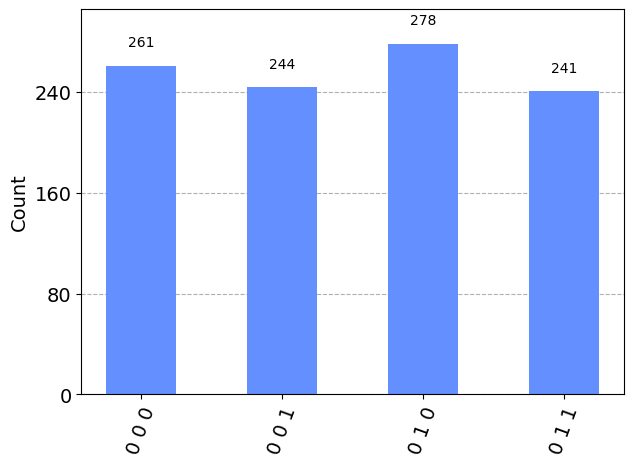

In [17]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

counts = AerSimulator().run(test).result().get_counts()
plot_histogram(counts)

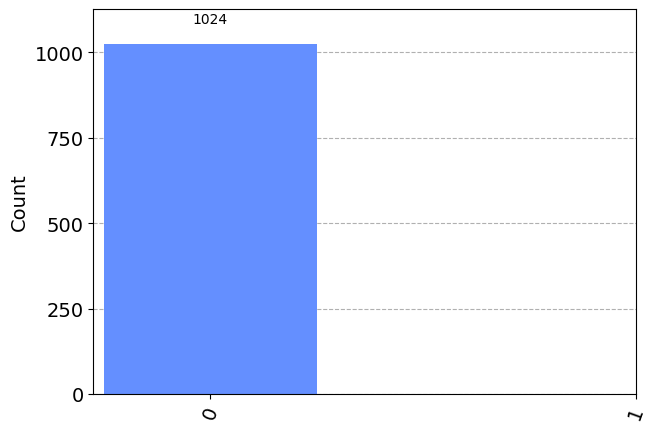

In [18]:
filtered_counts = {"0": 0, "1": 0}

for result, frequency in counts.items():
    filtered_counts[result[0] ] += frequency

plot_histogram(filtered_counts)

In [19]:
from qiskit import QuantumCircuit

protocol = QuantumCircuit(2)

# Prepare ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# Alice's operations

if b == "1":
    protocol.z(0)
if a == "1":
    protocol.x(0)
protocol.barrier()

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

protocol.draw()

┌───┐      ░  ░      ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├──■───░──░───■──┤ H ├─░─┤M├───
        └───┘┌─┴─┐ ░  ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──░─┤ X ├──────░──╫─┤M├
             └───┘ ░  ░ └───┘      ░  ║ └╥┘
meas: 2/══════════════════════════════╩══╩═
                                      0  1

Measured 00 with frequency 1024


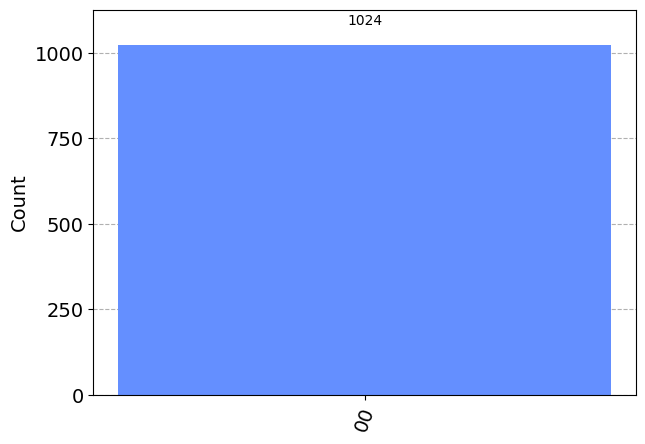

In [20]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

counts = AerSimulator().run(protocol).result().get_counts()
for outcome, frequency in counts.items():
    print(f"Measured {outcome} with frequency {frequency}")
plot_histogram(counts)

In [21]:
from qiskit import QuantumCircuit

rbg = QuantumRegister(1, "randomizer")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_a = ClassicalRegister(1, "Alice a")
Alice_b = ClassicalRegister(1, "Alice b")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_b, Alice_a)

# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Use the 'randomizer' qubit twice to generate Alice's bits a and b.
test.h(rbg)
test.measure(rbg, Alice_a)
test.h(rbg)
test.measure(rbg, Alice_b)
test.barrier()

# Now the protocol runs, starting with Alice's actions, which depend
# on her bits.
with test.if_test((Alice_b, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_a, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_a = ClassicalRegister(1, "Bob a")
Bob_b = ClassicalRegister(1, "Bob b")
test.add_register(Bob_b)
test.add_register(Bob_a)
test.measure(ebit1, Bob_a)
test.measure(ebit0, Bob_b)

test.draw()

░ ┌───┐┌─┐┌───┐┌─┐ ░              ░            ░       
randomizer: ───────────░─┤ H ├┤M├┤ H ├┤M├─░──────────────░────────────░───────
            ┌───┐      ░ └───┘└╥┘└───┘└╥┘ ░ ┌────┐┌────┐ ░      ┌───┐ ░    ┌─┐
         A: ┤ H ├──■───░───────╫───────╫──░─┤0   ├┤0   ├─░───■──┤ H ├─░────┤M├
            └───┘┌─┴─┐ ░       ║       ║  ░ │    ││    │ ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘
         B: ─────┤ X ├─░───────╫───────╫──░─┤  Z ├┤    ├─░─┤ X ├──────░─┤M├─╫─
                 └───┘ ░       ║       ║  ░ │    ││  X │ ░ └───┘      ░ └╥┘ ║ 
   Alice b: ═══════════════════╬═══════╩════╡0   ╞╡    ╞═════════════════╬══╬═
                               ║            └────┘│    │                 ║  ║ 
   Alice a: ═══════════════════╩══════════════════╡0   ╞═════════════════╬══╬═
                                                  └────┘                 ║  ║ 
     Bob b: ═════════════════════════════════════════════════════════════╬══╩═
                                                                         ║    
     Bob a: ═════════════════════════════════════════════════════════════╩════

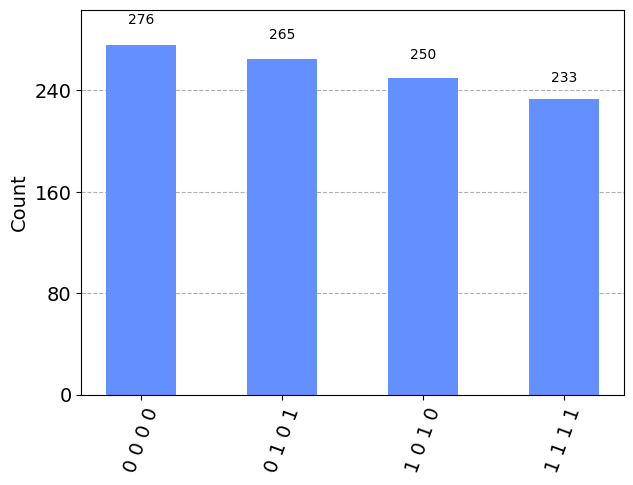

In [22]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

counts = AerSimulator().run(test).result().get_counts()
plot_histogram(counts)
